This will eventually be an introduction to numerical methods in partial differential equations. Over time, I hope to develop a resource which can be used to learn the theory and practice of numerical PDEs. The philosophy of this text is to be fully rigorous while connecting theory to practice with frequent coded examples of numerical solvers.

The essential prerequisites to be able to effectively use this text are calculus, linear algebra, and some coding knowledge. The first portion of this text is about finite difference methods, which are in effect carefully chosen Taylor approximations. Most other things can be picked up while reading.

The theory of numerical PDEs cannot exist apart from PDEs. Numerical schemes which work well for one type of PDE may fail miserably when adapted to even the simplest PDE of a different type. More importantly, knowledge of how the PDE can be solved and its solution informs the design of a numerical method to approximate its solution. PDEs with known exact solutions can be good test beds for numerical methods.

Let's start with an overview of some common PDEs. I make an attempt to use $t$ to represent a time-like variable and $x$ to represent a space-like variable. If there are three dimensions in particular, may use $\mathbf x = (x, y, z)$ I try to use a bold $\mathbf x$ to represent an $n$-dimensional space-like variable. I say time-like and space-like because there is mathematically no difference between the letters $x$ and $t$, but the nature of PDEs is such that the behavior of the solution may be qualitatively very different in the directions of different variables. The letters $u$ and $v$ commonly denote solutions to a PDE and are understood to be functions of $x$ and $t$. The partial derivative operators may be written as $\frac{\partial}{\partial x}$ or just $\partial_x$. The partial derivatives of $u$ are written as $u_x$ and $u_t$. Second derivatives are written similarly: $u_{tx} = (u_t)_x = \partial_x \partial_t u$. We freely assume that all solutions are sufficiently smooth that mixed partial derivatives commute, i.e., that $u_{xt} = u_{tx}$, etc. Note that there are [well-known examples](https://en.wikipedia.org/wiki/Symmetry_of_second_derivatives) in which this is not true.

The heat equation in one dimension: $u_t + au_{xx} = 0$, where $a > 0$ is a positive constant. The function $u$ models the evolution of temperature in a one-dimensional medium of constant thermal diffusivity $a$.

The heat equation in three dimensions: $u_t + a(u_{xx} + u_{yy} + u_{zz}) = 0$.

The wave equation: $u_{tt} = c^2(u_{xx} + u_{yy} + u_{zz})$.

The sum of all spatial second derivatives, $u_{xx} + u_{yy} + u_{zz}$, is common enough that it is given a dedicated symbol: $\Delta u$. So we can rewrite the heat equation as $u_t + a \Delta u = 0$ and the wave equation as $u_{tt} = c^2 \Delta u$. 

Poisson's equation: $\Delta u = f(\mathbf x)$, where $f$ is a function which may be specified. There is no time-like variable in this equation. If $f$ is just $0$, we get Laplace's equation: $\Delta u = 0$.

Black-Scholes equation: $v_t + \frac 1 2 \sigma^2 s^2 v_{ss} + r s v_s - r v = 0$, where $v$ is the price of a financial option on some stock, $s$ is the price of that stock, $r$ is the risk-free interest rate, and $\sigma$ is the volatility of the stock. This example emphasizes that PDEs need not model physical phenomena. 


The heat equation, the wave equation, and Laplace's equation all have significant physical importance and are archetypes for the three basic types of PDEs: parabolic, hyperbolic, and elliptic. Rather than define them, which takes some work, it is useful to describe them by their qualities. In parabolic equations, such as the heat equation, information travels with infinite speed. If our domain is the real interval $[-100, 100]$, then a change at the initial condition $u(-50, 0)$ for $x = -50$ will change the solution far away (say, $x = 50$) instantly: for any positive time $t > 0$, the solution $u(50, t)$ will be different than it would be without the change.

This is in stark contrast with the wave equation, in which information always travels with speed exactly $c$. If $c=1$, then a change at $x=-50$ can't be felt at $x=50$ until time $t = 100$. The behavior of information propagating at finite speed is the key feature of hyperbolic equations, such as the wave equation.

Lastly, elliptic PDEs (such as Poisson's equation and Laplace's equation) can be thought of as equations in which there is no time-like variable. They may represent the state of a system which is in equilibrium, i.e., not changing in time. This connection may be seen from the similarity between the heat equation and Laplace's equation. If we take the heat equation ($u_t + a \Delta u = 0$) and impose that the solution be in equilibrium, we get the condition that $u$ does not change in $t$, i.e., $u_t = 0$. If we make this substitution, we get the equation $a \Delta u = 0$, which is just Laplace's equation, and we see how in this case, the elliptic Laplace's equation may be thought of as a steady-state solution to the parabolic heat equation.

For the first portion of this text, we will focus on solutions to parabolic PDEs such as the heat equation. Taylor's formula is our primary tool to come up with a scheme. Remember that Taylor's formula tells us that if $f$ is a function which is at least $k+1$ times continuously differentiable at a point $x_0$, then $$f(x_0 + h) = f(x_0) + f'(x_0)h + f''(x_0) \frac {h^2}{2!} + \cdots + f^{(k)}(x_0) \frac{h^k}{k!} + R(h).$$
Notice that this is an equality, not an approximation. The uncertainty comes from not knowing what $R(h)$ is. Lagrange's form for the error tells us that 
$$R(h) = f^{(k+1)}(\xi_h) \frac{h^{k+1}}{(k+1)!},$$
where $\xi_h$ is some number between $x_0$ and $x_0+h$. There is still uncertainty here because we have no idea what $\xi_h$ is, only that it lies between $x_0$ and $x_0+h$. But if we know that $f^{(k+1)}(\xi)$ isn't too big for *any* $\xi$, then it doesn't matter what $\xi_h$ is. 


We made the assumption that $f^{(k+1)}(x)$ is continuous, so if the domain of our PDE is nice ([compact](https://en.wikipedia.org/wiki/Extreme_value_theorem)), then we know that $f^{(k+1)}(x)$ is bounded on the domain, that is, there is some number $M$ for which $|f^{(k+1)}(x)| \leq M$ for all $x$ in the domain. Then we can bound $|R(h)| \leq \frac M {(k+1)!} h^{k+1}$. In practice, we don't know or care how big $\frac M {(k+1)!}$ is, only that it is finite.


This brings us to the standard notation for tracking asymptotic errors: [big O notation](https://en.wikipedia.org/wiki/Big_O_notation). Big O notation is often used to indicate that one function doesn't grow any faster than another function, and thus we can ignore all but the most quickly growing term. It is most commonly used to compare functions as the inputs go to infinity, but for us it will be useful as the inputs go to $0$. We will also be using it for functions which may have more than one input. 

Formally, for functions $f(x, y)$ and $g(x, y)$, we say that $f$ is *big O* of $g$ (as $x$ and $y$ go to $0$), and write $f = O(g)$ or $f(x, y) = O(g(x, y))$, if there is a constant $C > 0$ such that whenever $x$ and $y$ are close enough to $0$, we have $|f(x, y)| \leq C g(x, y)$. The language "whenever $x$ and $y$ are close enough to $0$" is imprecise as written and means that there exist some positive values $x_0$ and $y_0$ such that whenever $|x| < x_0$ and $|y| < y_0$, the statement $|f(x, y)| \leq C g(x, y)$ is true. This may be modified in a clear way for functions which have only one or more than two inputs.

In this text, we will never use big O to measure the growth of functions as their inputs go to infinity, so we will suppress the language "as $x$ and $y$ go to $0$." Some examples will be illustrative:
- $\sqrt{x^2 + y^2} = O(1)$ because if $|x| \leq 1$ and $|y| \leq 1$, then $\sqrt{x^2 + y^2} \leq \sqrt{1 + 1} \leq 2$. Note that "$1$" may be thought of as the function whose value is always $1$. 
- $5x^3 = O(x^3)$ because if $|x| \leq 1$ then $5 x^3 \leq 6 (x^3)$. This illustrates that we really need to be able to put a constant in front of the function inside of $O(\cdot)$, or else this could never work.
- $x^3= O(x^2)$. This is the example to pay attention to. If $|x| < 1$, then $|x^3|/x^2 = |x| < 1$, and we see that $x^3$ is smaller than $x^2$.
- $\Delta x^2 + \Delta x^3 + \Delta t + \Delta t^3= O(\Delta x^2 + \Delta t)$. When we are working with powers of the variables, it is always the smallest power of that variable that is the limiting factor. Note that we are thinking of $\Delta x$ and $\Delta t$ as variables, so $\Delta x^3$ really means $(\Delta x)^3$. 

This allows us to precisely guarantee the accuracy of a Taylor approximation. For a second order approximation to a function $f$ with continuous third derivative, we have that $f(x+h) = f(x) + f'(x)h + f''(x)h^2/2 + R(h)$, where $R(h) = f'''(\xi_h) h^3/6$ for some $\xi_h$ between $x$ and $x+h$. We don't know exactly what $f'''(\xi_h)$ is, but we know that it is bounded by some constant $M$ (this uses the continuity of $f'''$ and compactness of the domain), and so $|R(h)| \leq h^3 M/6$. That is to say, $R(h) = O(h^3)$. This is a general fact about Taylor approximations: assuming the domain is nice and the derivatives are smooth, the $k$-th order Taylor approximation to $f(x+h)$ (which uses up to the $k$-th derivative of $f$) has error $O(h^{k+1})$. 

We will use this to track the error of discrete approximations of derivatives. Recall that the definition of the derivative of a function $f$ at a point $x$ is $$\lim_{h \to 0}\frac{f(x+h)-f(x)}{h}.$$
So if $h$ is small, the quantity $\frac{f(x+h)-f(x)}{h}$ should be a decent approximation of the derivative of $f$ at $x$. How good? We can use Taylor's formula to find out: $f(x+h) = f(x) + h f'(x) + O(h^2)$, so 
$$\frac{f(x+h)-f(x)}{h} = \frac{h f'(x) + O(h^2)}{h} = f'(x) + O(h).$$

This is not bad. As $h$ goes to $0$, this quantity approaches $f'(x)$, which is exactly what we would expect from the limit definition of the derivative. The speed at which it approaches $f'(x)$ is $O(h)$, but we can actually do better than this using the *centered difference*. By substituting $-h$ for $h$, we can quickly get a Taylor approximation for $f(x-h)$:
$$f(x - h) = f(x) - f'(x)h + f''(x) \frac {h^2}{2!} - f'''(x) \frac{h^3}{3!} + \cdots + (-1)^k f^{(k)}(x) \frac{h^k}{k!} + O(h^{k+1}).$$

The centered difference approximation to the derivative is $\frac{f(x+h)-f(x-h)}{2h}$. We analyze this using $f(x+h) = f(x) + h f'(x) + h^2 f''(x)/2 + O(h^3)$ and $f(x-h) = f(x) - h f'(x) + h^2 f''(x)/2 + O(h^3)$. When subtracting, the $f(x)$ terms cancel just like in the forward difference approximation, but now the $h^2 f''(x)/2$ terms cancel as well, giving
$$\frac{f(x+h)-f(x-h)}{2h} = \frac{2 h f'(x) + O(h^3)}{2h} = f'(x) + O(h^2/2) = f'(x) + O(h^2).$$
Since constants don't matter for whether a function is big O of another, we can always remove any constants that make their way into a big O expression. The centered difference now has accuracy $O(h^2)$, which converges substantially faster than $O(h)$. Or from another perspective, if we want accuracy to be on the order of $10^{-6}$, we only need our discretization spacing to be about $10^{-3}$. Since this is essentially a free improvement, we will use this whenever we can. It has the additional advantage of being symmetric, so it cannot introduce bias in one direction to a symmetric problem. 

Just like the forward difference operator, there is also the backward difference operator: $(f(x)-f(x-h))/h = f'(x) + O(h)$. The other discrete approximation we will rely on heavily is the discrete second derivative. If we start with the forward difference approximation to the derivative and then apply the backward difference approximation to *that expression*. The forward difference is $(f(x+h)-f(x))/h$. The backward difference approximation of $f(x+h)$ is $(f(x+h) - f(x))/h$ and that of $f(x)$ is $(f(x) - f(x-h))/h$. Putting this together, the backward difference of the forward difference of f(x)$ is
$$
\frac{f(x+h) - f(x) - (f(x) - f(x-h))}{h^2} = \frac{f(x-h) - 2 f(x) + f(x+h)}{h^2}.
$$
A Taylor approximation of order $3$ gives $f(x+h) = f(x) + h f'(x) + h^2 f''(x)/2 + h^3 f'''(x)/6 + O(h^4)$ and $f(x-h) = f(x) - h f'(x) + h^2 f''(x)/2 - h^3 f'''(x)/6 + O(h^4)$. Add these together and subtract $2f(x)$ to get that
$$
\frac{f(x-h) - 2f(x) + f(x+h)}{h^2} = \frac{h^2 f''(x) + O(x^4)}{h^2} = f''(x) + O(h^2).
$$
This matches the centered difference approximation for the derivative in accuracy.

It can be a good idea to use Taylor approximations to one term more than needed so that the actual constant that big O hides becomes apparent. For example, we can estimate the centered difference using
$$
f(x+h)-f(x-h) = 2h f'(x) + 2h^3 f'''(x)/3! + O(h^5),
$$
so $(f(x+h)-f(x-h))/2h = f'(x) + h^2 f'''(x)/6 + O(h^5)$, and we see not only that this is second order accurate, but also that the specific constant is $f'''(x)/6$. 

It's time to test out these approximations numerically on a function we know well. We'll use $f(x) = \sin(x)$ at $x=1$. You can execute the following code if you are viewing this notebook in a Jupyter environment, or start your own python environment and code yourself. If you do not write your own code, you should always at least play around with changing some things about the code and seeing how the results change. For example, change the function, try new values of $h$, or implement a different approximation scheme. The code uses NumPy (think "numerical Python") and Matplotlib. Even if Python is installed on the computer you are using, they might not be. An internet search can help find installation instructions. NumPy is a package which provides many commonly used numerical functions as well as data types for efficiently working with large multidimensional arrays. It is highly optimized, and most computationally intensive parts are written in (again, highly optimized) C, giving much faster performance than is possible in native Python. Matplotlib is a plotting library, allowing us to quickly make figures and plot our results.

In [20]:
import numpy as np # NumPy will provide the values of sin for us
import matplotlib.pyplot as plt

x = 2
h_vals = np.array([2**-3, 2**-5, 2**-7, 2**-9, 2**-11])
                # The operator ** is exponentiation
forward_derivative = (np.sin(x + h_vals) - np.sin(x))/h_vals
                # when NumPy does an operation on arrays, it does it element
                # by element. The expression x + h_vals adds x to each element
                # of h_vals, etc.
center_derivative = (np.sin(x + h_vals) - np.sin(x - h_vals))/(2 * h_vals)
true_derivative = np.cos(x)
forward_error = np.abs(forward_derivative - true_derivative)
center_error = np.abs(center_derivative - true_derivative)

At this point, we can compare the errors, but they may be the most useful on a log-log plot. Whenever we expect the output to follow a power law of the input, and especially when we have an exponentially varying inputs, a log-log plot can make the power clear. 

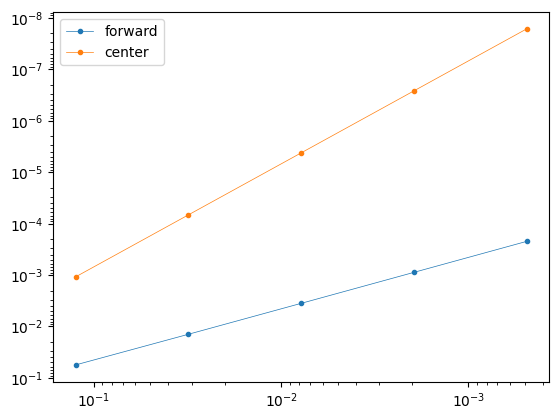

In [46]:
plt.loglog(h_vals, forward_error, '.-', linewidth = .5, label = 'forward')
plt.loglog(h_vals, center_error, '.-', linewidth = .5, label = 'center')
# the '.-' argument says to have points marking the data points and
# a solid line connecting the dots
plt.gca().invert_xaxis() # these lines invert the axes so that up/right 
plt.gca().invert_yaxis() # represents increasing accuracy (closer to 0)
plt.legend() # this adds a legend
plt.show()   # this actually shows the plot

We are often interested in numerically investigating a rate of convergence. If we happen to know that the error $E(h)$ satisfies $E(h) = C h^p$ for some $p$, then we would find $\log |E(h)| = p \log(h) + \log|C|$. This means that $\log |E(h)|$ is a linear function in $\log(h)$ with slope $p$, so running a linear regression to find the slope is a good way of estimating $p$. Since we expect this relationship to be quite robust, we don't need to worry terribly about any details of the regression analysis beyond the slope. Let's do this.

In [42]:
log_h = np.log(h_vals)
log_for_err = np.log(forward_error)
log_ctr_err = np.log(center_error)
A = np.stack([log_h, np.ones(len(log_h))]).T
# The numpy least squares function takes in a matrix A and vector b and 
# returns the vector x which best approximates Ax = b (where Ax is matrix
# multiplication) in a least-squares sense. The vector b will be our outcomes,
# and A will be our inputs: log_h and a constant term. The np.ones() function
# makes an array of constant ones, np.stack puts this vector next to log_h,
# and the .T transposes this so it is in the correct orientation for
# matrix multiplication.
for_exp = np.linalg.lstsq(A, log_for_err, rcond = None)[0][0]
ctr_exp = np.linalg.lstsq(A, log_ctr_err, rcond = None)[0][0]
# rcond is mildly technical and you don't need to worry about.
# Read the documentation for linalg.lstsq to confirm that the [0][0] extracts
# the correct coefficient from the regression. 
print("Forward error exponent: " + np.array2string(for_exp))
print("Center error exponent: " + np.array2string(ctr_exp))

Forward error exponent: 0.99671469
Center error exponent: 1.99988438


We see that this matches with the error rates of $O(h)$ and $O(h^2)$ that we expected for forward and center difference. 

By now, you should have an understanding of how to use Taylor's formula to evaluate the accuracy of discrete approximations to derivatives, how to numerically implement these, and how to numerically evaluate their accuracy. The exercises contain more work with Taylor approximations. Notably, they outline how to design your own accurate Taylor approximations for higher derivatives.

#### Exercises:
1. Use Taylor approximations to show that $(f(x) + f(x+h))/2 = f(x+h/2) + O(h^2)$.
1. Similarly, show that the forward difference is second order accurate around the point $x+h/2$.
1. Design a numerical approximation to the third derivative. Choose coefficients $a_{-2}, a_{-1}, \dots, a_2$ such that $a_{-2} f(x-2h) + a_{-1} f(x-h) + a_0 f(x) + a_1 f(x+h) + a_2 f(x+2h) = f'''(x) + O(h).$ Use the (trivial) fact that 
$f'''(x) = 0 \cdot f(x) + 0 \cdot f'(x) + 0 \cdot f''(x) + f'''(x) + 0 \cdot f^{(4)}(x)$. We know that each $f(x+nh)$ can be expressed as a linear combination of $f(x), \dots, f^{(4)}(x)$, plus $O(h^5)$. Linear algebra tells us that, as long as these are linearly independent linear combinations, since we have $5$ unknowns on the left and $5$ specified coefficients on the right, there must be a solution. If we are lucky, we may have terms cancel for free. Can you find the third derivative approximation using the $5$ grid points $x-2h, \dots, x+2h$ of best order? Can you make it symmetric? Numerically implement your approximation and evaluate its accuracy. Does that match what you expected from the Taylor analysis?
 

TODO: Add remarks about why higher order isn't always better; can reference https://scicomp.stackexchange.com/questions/5587/what-are-the-negatives-of-using-higher-order-finite-diference-schemes for ideas